In [4]:
import os
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import pandas as pd
import csv
from glob import glob
from sklearn.metrics import f1_score

In [5]:
id2label = {
    0: 'Idle',
    1: 'Toric Marking',
    2: 'Implant Ejection',
    3: 'Incision',
    4: 'Viscodilatation',
    5: 'Capsulorhexis',
    6: 'Hydrodissetion',
    7: 'Nucleus Breaking',
    8: 'Phacoemulsification',
    9: 'Vitrectomy',
    10: 'Irrigation/Aspiration',
    11: 'Preparing Implant',
    12: 'Manual Aspiration',
    13: 'Implantation',
    14: 'Positioning',
    15: 'OVD Aspiration',
    16: 'Suturing',
    17: 'Sealing Control',
    18: 'Wound Hydratation',
}

label2id = {v: k for k, v in id2label.items()}

## 推論結果の可視化

In [36]:
predict_csv = '/data1/github/MICCAI2020/cataractsWorkflow/result/cnn_only/tf-xception-skipframe=1/predict/train/23/train23.csv'
target_csv = '/data1/github/MICCAI2020/cataractsWorkflow/data/train/23/train23.csv'

In [37]:
df_pr = pd.read_csv(predict_csv)
df_gt = pd.read_csv(target_csv)

In [49]:
df_pr

,Frame,Steps
0,1,11
1,2,11
2,3,11
3,4,11
4,5,11
...,...,...
11177,11178,0
11178,11179,0
11179,11180,0
11180,11181,0


In [128]:
map_ = np.eye(19)[df_gt['Steps']].T

In [133]:
map_.shape

(19, 11182)

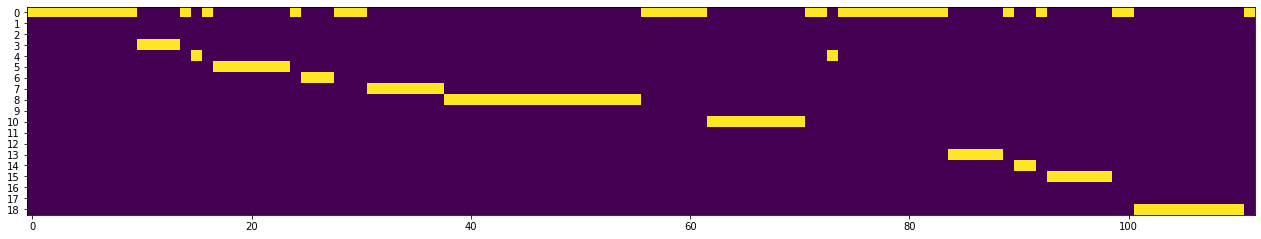

In [136]:
plt.figure(figsize=(22, 14))
plt.yticks(np.arange(0, 19, 1))
plt.imshow(np.eye(19)[df_gt['Steps']].T[:, ::100])

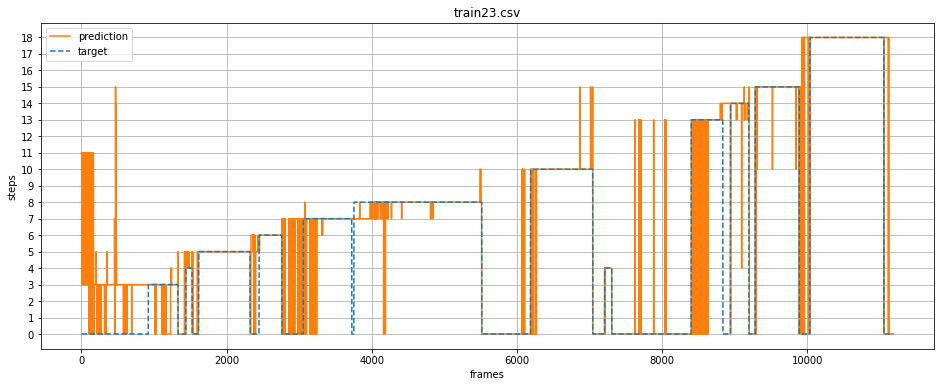

In [99]:
# build instance
plt.figure(figsize=(16, 6))
plt.gca().get_yaxis().set_major_locator(ticker.MaxNLocator(integer=True))  # 縦軸目盛を整数に

# plot
plt.plot(df_pr['Frame'], df_pr['Steps'], label='prediction', color='tab:orange')
plt.plot(df_gt['Frame'], df_gt['Steps'], label='target', color='tab:blue', linestyle='dashed')

plt.title(os.path.basename(target_csv))
plt.xlabel('frames')
plt.ylabel('steps')
plt.yticks(np.arange(0, 19, 1))  # 縦軸目盛を明示的につける
plt.grid()
plt.legend()

plt.show()